In [1]:
import os, random

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import regularizers
from tensorflow.contrib.keras import models

%matplotlib inline

/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
PNG_DIR = 'spectrogram_images/'
IMG_DIR = 'spectrogram_jpg/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 6
NUM_EPOCHS = 20
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [4]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = []
for i in range(7):
    sample_files.append(random.choice(os.listdir(IMG_DIR)))
    
label_dict = {  'Jingle':0,
                'Lullaby':1,
                'Video_game_music':2,
                'Christmas_music':3,
                'Dance_music':4,
                'Wedding_music':5} 

one_hot = OneHotEncoder(n_values=NUM_CLASSES)

all_files = os.listdir(IMG_DIR)

# Get class weights
label_array = []
for file_ in list(all_files):
    vals = file_[:-4].split('_', 1)[1]
    if vals in ['Background_music', 'Theme_music', 'Soundtrack_music']:
        all_files.remove(file_)
    else:
        label_array.append(label_dict[vals])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

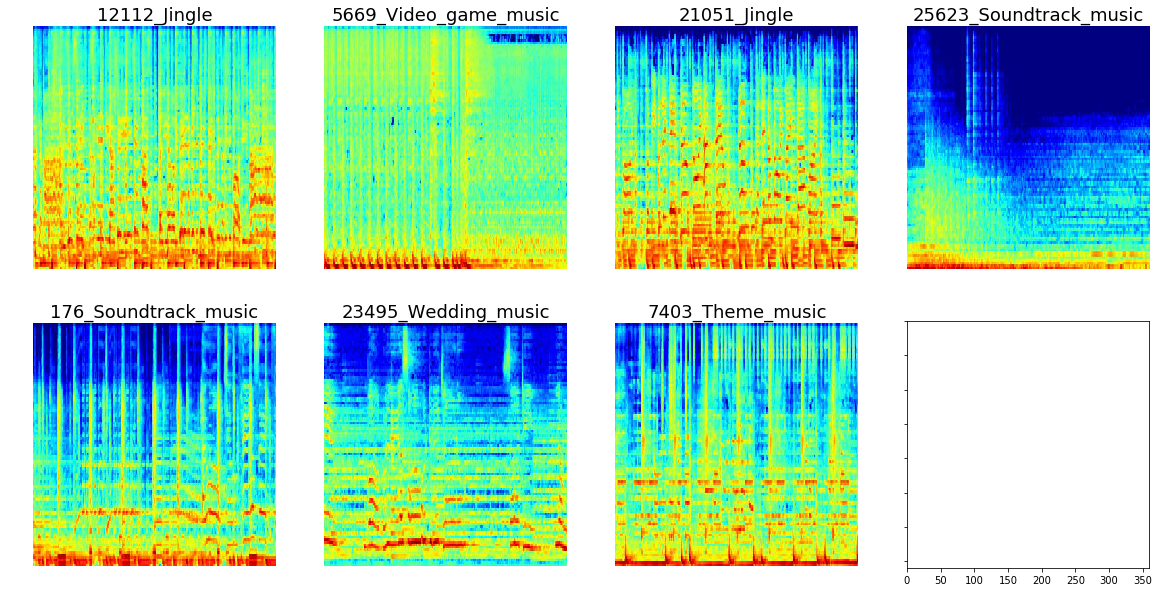

In [5]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(IMG_DIR + file_)
    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)


Samples above show that the spectrograms are different for different genres.

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4, 4), strides=(1, 1), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), data_format='channels_last'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (4, 4), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, (4, 4), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (4, 4), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES))
model.add(layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 216, 32)      1568      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 216, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 213, 213, 32)      16416     
_________________________________________________________________
activation_2 (Activation)    (None, 213, 213, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 64)        32832     
__________

In [7]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_', 1)
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [8]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [9]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(lr=1e-4)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/cnn_epoch_reduced_dataset_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              class_weight = cl_weight, # Check if providing class weight is useful
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                             )

Epoch 1/20
96/96 [==============================] - 66s 684ms/step - loss: 3.0745 - categorical_accuracy: 0.2269 - val_loss: 2.9040 - val_categorical_accuracy: 0.2562
Epoch 2/20
96/96 [==============================] - 26s 276ms/step - loss: 2.7470 - categorical_accuracy: 0.3066 - val_loss: 2.7329 - val_categorical_accuracy: 0.2188
Epoch 3/20
96/96 [==============================] - 27s 282ms/step - loss: 2.5564 - categorical_accuracy: 0.3386 - val_loss: 2.5642 - val_categorical_accuracy: 0.2062
Epoch 4/20
96/96 [==============================] - 27s 278ms/step - loss: 2.3951 - categorical_accuracy: 0.3756 - val_loss: 2.4158 - val_categorical_accuracy: 0.2687
Epoch 5/20
96/96 [==============================] - 27s 280ms/step - loss: 2.2686 - categorical_accuracy: 0.3883 - val_loss: 2.2737 - val_categorical_accuracy: 0.3063
Epoch 6/20
96/96 [==============================] - 27s 277ms/step - loss: 2.1534 - categorical_accuracy: 0.4030 - val_loss: 2.1560 - val_categorical_accuracy: 0.356

In [12]:
# Save scores on train and validation sets
with open('pickle_files/cnn_reduced.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Determine the best performing model

In [13]:
# Load scores
with open('pickle_files/cnn_reduced.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores)#, index=range(1,30))

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


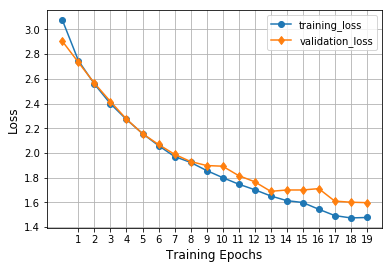

In [14]:
plt.xticks(range(1,30))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

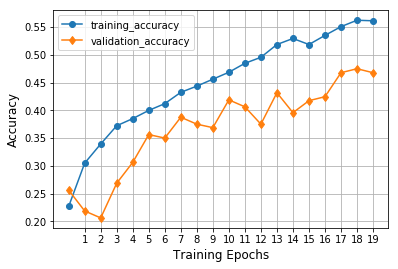

In [15]:
plt.xticks(range(1,30))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

In [16]:
model = models.load_model(filepath='saved_models/cnn_epoch_reduced_dataset_19_0.4748.h5') 

In [17]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

### Evaluation of the best performing model

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization


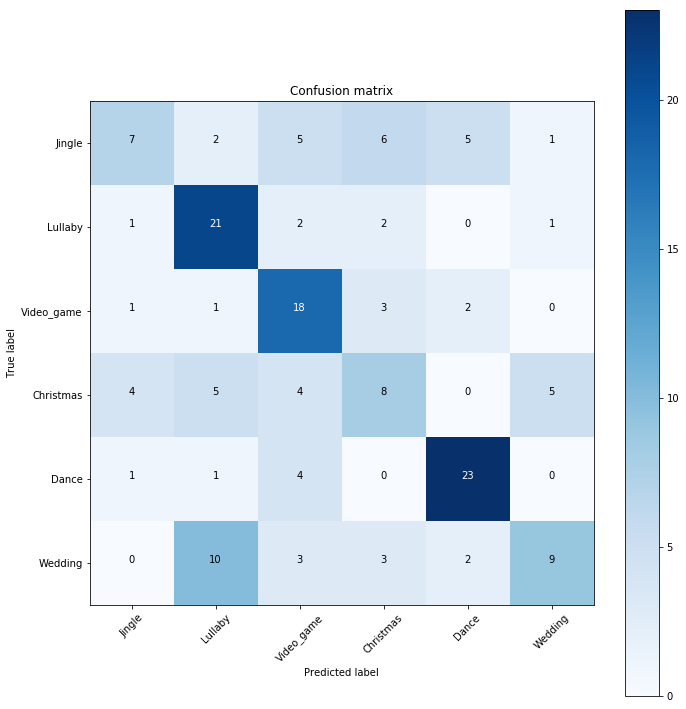

In [19]:
roles = ['Jingle', 'Lullaby', 'Video_game', 'Christmas', 'Dance', 'Wedding']
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=roles)

In [20]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.54
Test Set F-score =  0.51


In [21]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.837


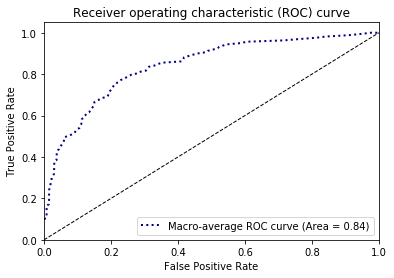

In [22]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()